<a href="https://colab.research.google.com/github/IagoMagalhaes23/Yolo/blob/main/YoloV8_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yolo V8 e SAM
**-Autor:** Iago Magalhães

Imagine que você tem um conjunto de dados de imagens contendo objetos de interesse, com cada imagem anotada com caixas delimitadoras. Embora as caixas delimitadoras forneçam informações posicionais sobre objetos, elas não possuem os detalhes necessários para tarefas mais avançadas de visão computacional, como segmentação de instâncias ou remoção de plano de fundo.

A conversão de caixas delimitadoras em máscaras de segmentação nos permite extrair limites precisos dos objetos e separá-los do fundo, abrindo novas oportunidades de análise e manipulação.

Fonte: Arty Ariuntuya . (7 de junho de 2023). Como usar Ultralytics YOLOv8 com SAM. Blog do Roboflow: https://blog.roboflow.com/how-to-use-yolov8-with-sam/

##Instalações

In [ ]:
!pip install roboflow ultralytics 'git+https://github.com/facebookresearch/segment-anything.git'

##Importações

In [2]:
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Set the device for GPU acceleration
device = "cuda"

# Check Ultralytics version and setup completion
ultralytics.checks()

# Set the first_run flag to False after the initial run
first_run = True

if first_run:
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/78.2 GB disk)
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-o1n1rpq8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-o1n1rpq8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-05-08 12:05:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[=====

##Executando a inferência YOLOv8

In [3]:
# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Perform object detection on the image
results = model.predict(source='/content/WIN_20240501_17_38_27_Pro.jpg', conf=0.25)


image 1/1 /content/WIN_20240501_17_38_27_Pro.jpg: 384x640 1 person, 1 tie, 1 snowboard, 1 skateboard, 1 chair, 109.3ms
Speed: 17.0ms preprocess, 109.3ms inference, 707.1ms postprocess per image at shape (1, 3, 384, 640)


##Extraindo a caixa delimitadora

In [4]:
for result in results:
    boxes = result.boxes
    bbox = boxes.xyxy.tolist()[0]

In [5]:
print(bbox)

[282.8375244140625, 72.72735595703125, 1049.439697265625, 713.8051147460938]


##Converter caixa delimitadora em máscara de segmentação usando SAM

In [6]:
image = cv2.cvtColor(cv2.imread('/content/WIN_20240501_17_38_27_Pro.jpg'), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [16]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box = np.expand_dims(bbox, axis=0),
    multimask_output=False,
)

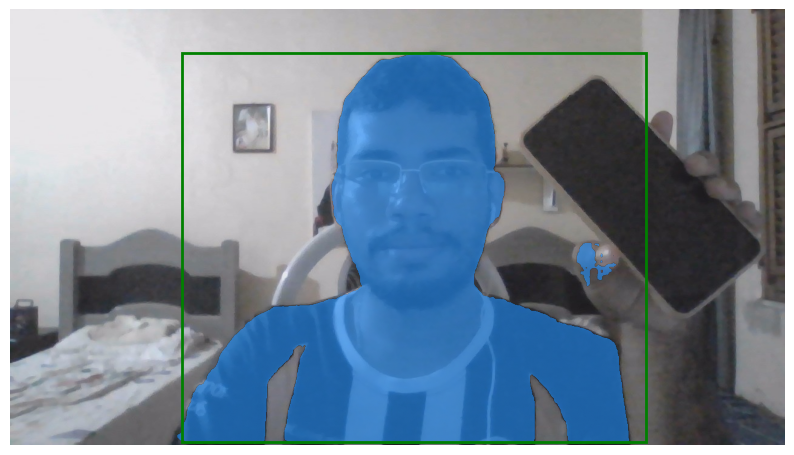

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

##Remoção de fundo

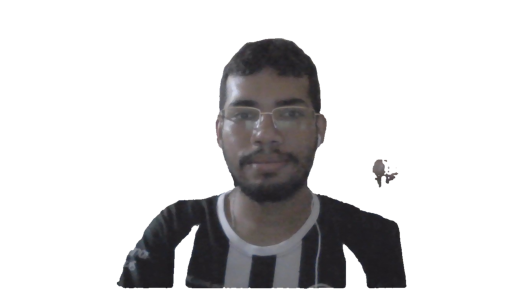

In [18]:
segmentation_mask = masks[0]

# Convert the segmentation mask to a binary mask
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)
white_background = np.ones_like(image) * 255

# Apply the binary mask
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

##Referências
- [Como usar Ultralytics YOLOv8 com SAM](https://blog.roboflow.com/how-to-use-yolov8-with-sam/)
- [Segment Anything Model (SAM)](https://blog.roboflow.com/how-to-use-yolov8-with-sam/#:~:text=Segment%20Anything%20Model%20(SAM))
- [YoloV8](https://blog.roboflow.com/whats-new-in-yolov8/)